<center><h2>Inter-IIT Tech Meet 2018</h2> 
<h3> Optimal Bidding (Part I - Section C) </h3><br></center>
<b>Author</b> : Alan Aipe <br>
<b>Last Updated Date</b> : 15-12-2017 <br>
<b>Description</b> : Solar power plant output optimization - A signal processing + simple machine learning approach

In [13]:
#External Libraries
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import math

Solar power output optimization algorithm involves following steps:
1. It is observed that predicted solar output is almost similar as real output but is more gittery. So inorder to smoothen out the daily curve, Savitzky-Golay filter is used. As number of times to use the filter on a particular curve is dependent on the the curve itself, this algorithm learns a weight corresponding to nth time the filter is used from the training dataset.
2. Weighted average of n-curves, generated by using the filter repeatedly, is taken.
3. In nature, dynamic outputs tend to be smooth. Valleys in the above curve are optimized by projecting a parabola between neighbouring points and updating valley point to be the peak of the projected parabola. This is not done for peaks because as the solar output tend to increase then decrease, therefore there is a possibility of big spikes at the highest point of curve. Updation of the weighted curve with the parabolic height tend to increase the error

In [14]:
# Learning weights from dataset.
# Loading training dataset.
dataset = scipy.io.loadmat('OptimalBiddingTrain.mat')
# Global variables
n_iter = 100
r_start = 1
r_end = 160
n_savgolFilter = 3
solar_hour_start = 7
solar_hour_end = 18
avg_wt_vector = np.zeros(n_savgolFilter+1)
# Here total training dataset is divided into 5 parts. Weight vector with respect to each part is calculated
# and average is taken.
for k in range(5):
    freq = np.zeros(n_iter)
    for j in range(r_start,r_end):
        n1 = j
        n2 = n1
        n_days = 1
        offset = 0
        solar_pred = (dataset['Solar_Train_pred'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
        solar_real = (dataset['Solar_Train'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
        prev_error = np.sum((solar_pred-solar_real)*(solar_pred-solar_real))/24
        result = solar_pred
        for i in range(n_iter):
            yhat = savgol_filter(x = result[solar_hour_start:solar_hour_end] , window_length=5,polyorder=3)
            result = np.concatenate((solar_pred[:solar_hour_start],yhat,solar_pred[solar_hour_end:]))
            error = np.sum((result-solar_real)*(result-solar_real))/24
            if error >= prev_error:
                break
            prev_error = error
        freq[i]+=1
    weight_vector = freq/160.0
    weight_vector[0] += sum(weight_vector[n_savgolFilter+1:])
    weight_vector = weight_vector[:n_savgolFilter+1]
    avg_wt_vector += weight_vector
    r_start += 160
    r_end += 160
    
avg_wt_vector /= 5
weight_vector = avg_wt_vector
# Weight vector has only 11 elements because formost of cases, applying filter 10 times is enough to optimize 
# the gitters. This was observed during experiment
print("Learned Weight Vector : ",weight_vector)

Learned Weight Vector :  [ 0.56     0.11875  0.24875  0.06625]


In [15]:
# Loading test dataset. Here both training and test dataset are same. This result was verified with
# 5-cross validation as well.
dataset = scipy.io.loadmat('OptimalBiddingTrain.mat')
#weight_vector = [0.1925,0.275,0.325,0.06625,0.05,0.02875,0.02125,0.01125,0.01125,0.005,0.0075]
optimized_solar_output = []
count = 0
abs_error=0
total_error=0
for n1 in range(1,901):
    n2 = n1
    ndays = 1
    solar_pred = (dataset['Solar_Train_pred'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
    solar_real = (dataset['Solar_Train'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
    result = solar_pred
    error1 = np.sum((result-solar_real)*(result-solar_real))/24
    wt_avg = weight_vector[0]*result
    
    for i in range(24-3):
            f = solar_pred[i+1]
            m1 = solar_pred[i+1]-solar_pred[i]
            m2 = solar_pred[i+2]-solar_pred[i+1]
            delta = 0
            flag = 0
            if m1<0 and m2>0:
                flag = 2
                if abs(m1)>abs(m2):
                    k = i+((solar_pred[i+2]-solar_pred[i])/(solar_pred[i+1]-solar_pred[i]))
                    if solar_pred[i+1] > solar_pred[i+2]-((i+2-k)*(i+2-k)/4.0):
                        delta = (solar_pred[i+2]-((i+2-k)*(i+2-k)/4.0)-solar_pred[i+1])
                    else:
                        delta = solar_pred[i+2]-((i+2-k)*(i+2-k)/4.0) - solar_pred[i+1]
                elif abs(m1)<abs(m2):
                    k = i+2 - ((solar_pred[i+2]-solar_pred[i])/(solar_pred[i+2]-solar_pred[i+1]))
                    if solar_pred[i+1] > solar_pred[i]-((k-i)*(k-i)/4.0):
                        delta = (solar_pred[i]-((k-i)*(k-i)/4.0)-solar_pred[i+1])
                    else:
                        delta = solar_pred[i]-((k-i)*(k-i)/4.0)-solar_pred[i+1]
            delta =  abs(delta)
            if wt_avg[i+1]<wt_avg[i] and wt_avg[i+1]<wt_avg[i+2]:
                wt_avg[i+1]+= delta
            elif flag == 2 and wt_avg[i+1]<wt_avg[i] and wt_avg[i+1]>wt_avg[i+2]:
                wt_avg[i+1]-= delta
            elif flag == 2 and wt_avg[i+1]>wt_avg[i] and wt_avg[i+1]<wt_avg[i+2]:
                wt_avg[i+1]+= delta
    for i in range(n_savgolFilter):
            yhat = savgol_filter(x = result[solar_hour_start:solar_hour_end] , window_length=5,polyorder=3) #6th block to 18th block is considered because in other blocks outputis always zero
            yhat[yhat<0] = 0
            result = np.concatenate((solar_pred[:solar_hour_start],yhat,solar_pred[solar_hour_end:]))
            wt_avg+= weight_vector[i+1]*result
            
    error2 = np.sum((wt_avg-solar_real)*(wt_avg-solar_real))/24
    if error2<error1:
        count+=1
    total_error += error1
    abs_error += (error1-error2)
    optimized_solar_output.append(wt_avg)

print("Algorithm was able to decrease mean square error for",count,"days out of 900 days.")
print("Algorithm optimized the prediction on an average by ",np.round(100.0*abs_error/total_error,2),"% with respect to mean square error \n between optimized and real output.")

Algorithm was able to decrease mean square error for 853 days out of 900 days.
Algorithm optimized the prediction on an average by  31.8 % with respect to mean square error 
 between optimized and real output.


Output of this section is given by 'optimized_solar_output' variable

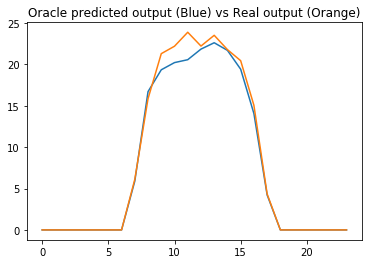

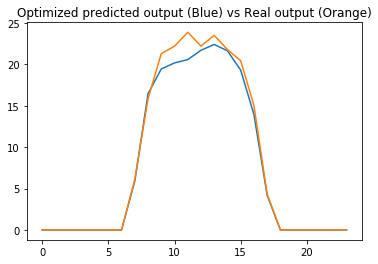

0.9394375 0.952910053878


In [16]:
#Sample curve to visually see the optimization
#Day 1
n1 = 414#(int) (0.8 * 900)#np.random.randint(900)+1
n_days = 1
solar_pred = (dataset['Solar_Train_pred'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
solar_real = (dataset['Solar_Train'].flatten())[(n1-1)*24+offset:(n1-1)*24+int(n_days*24)]
solar_optimized = optimized_solar_output[n1-1] 
plt.plot(range(24),solar_pred)
plt.plot(range(24),solar_real)
plt.title("Oracle predicted output (Blue) vs Real output (Orange)")
plt.show()
error1 = np.sum((solar_pred-solar_real)*(solar_pred-solar_real))/24
plt.plot(range(24),solar_optimized)
plt.plot(range(24),solar_real)
error2 = np.sum((solar_optimized-solar_real)*(solar_optimized-solar_real))/24
plt.title("Optimized predicted output (Blue) vs Real output (Orange)")
plt.show()
print(error1,error2)

In [17]:
np.array(optimized_solar_output).shape[0]


900

(24, 1)


Using TensorFlow backend.


Epoch 1/51
900/900 [==============================] - 39s - loss: 5.6707    
Epoch 2/51
900/900 [==============================] - 26s - loss: 1.0159    
Epoch 3/51
900/900 [==============================] - 25s - loss: 0.9329    
Epoch 4/51
900/900 [==============================] - 25s - loss: 0.9077    
Epoch 5/51
900/900 [==============================] - 25s - loss: 0.8714    
Epoch 6/51
900/900 [==============================] - 26s - loss: 0.8613    
Epoch 7/51
900/900 [==============================] - 26s - loss: 0.8615    
Epoch 8/51
900/900 [==============================] - 26s - loss: 0.8422    
Epoch 9/51
900/900 [==============================] - 26s - loss: 0.8428    
Epoch 10/51
900/900 [==============================] - 25s - loss: 0.8420    
Epoch 11/51
900/900 [==============================] - 26s - loss: 0.8427    
Epoch 12/51
900/900 [==============================] - 26s - loss: 0.8176    
Epoch 13/51
900/900 [==============================] - 26s - loss: 0.8198

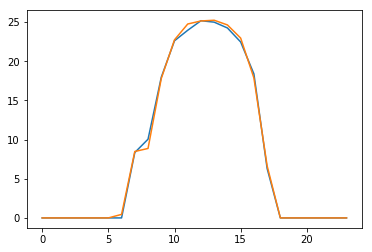

In [18]:
opt_matrix = np.reshape(np.array(optimized_solar_output),(-1,24,1))
print(opt_matrix[0].shape)
solar_pred = dataset["Solar_Train_pred"]
solar_real = np.reshape(dataset["Solar_Train"],(-1,24,1))
from keras.layers import LSTM, Bidirectional,Dense
from keras.models import Sequential
model = Sequential()
model.add(Bidirectional(LSTM(15, activation='relu',return_sequences=True), input_shape=(13,1)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(opt_matrix[:,6:19,:], solar_real[:,6:19,:], batch_size=1, epochs=51)
y_pred = model.predict(opt_matrix[:,6:19,:])
y_pred = np.reshape(y_pred,(900,13,))
solar_real = np.reshape(solar_real,(900,24,))
final_output = []
for i in range(900):
    final_output.append(np.concatenate((solar_pred[i,:6],y_pred[i],solar_pred[i,19:])))
final_output = np.array(final_output)
total_error=0
opterror = 0
count = 0
for i in range(900):
    error1 = np.sum((solar_pred[i]-solar_real[i])*(solar_pred[i]-solar_real[i]))/24
    error2 = np.sum((final_output[i]-solar_real[i])*(solar_pred[i]-solar_real[i]))/24
    total_error += error1
    if error1>error2:
        count+=1
    opterror += (error1-error2)
print("Algorithm was able to decrease mean square error for",count,"days out of 900 days.")
print("Algorithm optimized the prediction on an average by ",np.round(100.0*opterror/total_error,2),"% with respect to mean square error \n between optimized and real output.")
plt.plot(range(24),np.concatenate((np.zeros(6),y_pred[100],np.zeros(5))))
plt.plot(range(24),solar_real[100])
plt.show()

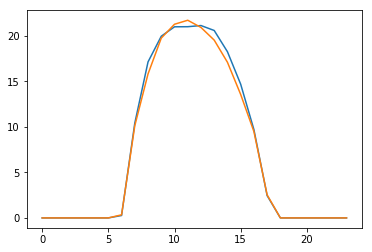

In [19]:
plt.plot(range(24),final_output[233])
plt.plot(range(24),dataset["Solar_Train"][233])
plt.show()

In [20]:
model.save('solar_opt_bilstm_model.h5')

Train on 720 samples, validate on 180 samples
Epoch 1/51
720/720 [==============================] - 15s - loss: 1.3211 - val_loss: 0.2980
Epoch 2/51
720/720 [==============================] - 1s - loss: 0.2474 - val_loss: 0.2052
Epoch 3/51
720/720 [==============================] - 1s - loss: 0.2315 - val_loss: 0.1265
Epoch 4/51
720/720 [==============================] - 1s - loss: 0.1760 - val_loss: 0.2856
Epoch 5/51
720/720 [==============================] - 1s - loss: 0.1470 - val_loss: 0.1024
Epoch 6/51
720/720 [==============================] - 1s - loss: 0.1338 - val_loss: 0.0848
Epoch 7/51
720/720 [==============================] - 1s - loss: 0.1446 - val_loss: 0.0962
Epoch 8/51
720/720 [==============================] - 1s - loss: 0.1325 - val_loss: 0.0755
Epoch 9/51
720/720 [==============================] - 1s - loss: 0.1261 - val_loss: 0.0758
Epoch 10/51
720/720 [==============================] - 1s - loss: 0.1006 - val_loss: 0.0680
Epoch 11/51
720/720 [=====================

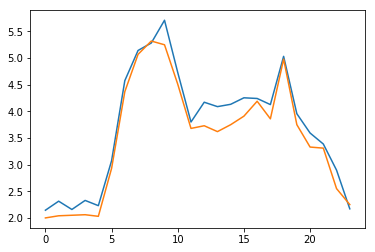

In [21]:
price_real = np.reshape(dataset["Price_Train"],(-1,24,1))
price_pred = np.reshape(dataset["Price_Train_pred"],(-1,24,1))
model = Sequential()
model.add(Bidirectional(LSTM(20, activation='relu',return_sequences=True), input_shape=(24, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(price_pred, price_real+0.01, batch_size=32, epochs=51,validation_split=0.2)
y_pred = model.predict(price_pred)
count1 = 0
count2 = 0
y_pred = np.reshape(y_pred,(900,24,))
price_real = np.reshape(price_real,(900,24,))
for i in range(len(y_pred)):
    error1 = np.sum((price_pred[i]-price_real[i])*(price_pred[i]-price_real[i]))/24
    error2 = np.sum((y_pred[i]-price_real[i])*(y_pred[i]-price_real[i]))/24
    if error1 > error2:
        count1+=1
    for j in range(24):
        if y_pred[i,j]>price_real[i,j]:
            count2+=1
print(count1,count2)
plt.plot(range(24),y_pred[100])
plt.plot(range(24),price_real[100])
plt.show()